In [1]:
import os
os.chdir(os.getcwd())

## Import Module

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Import Data

In [3]:
df = pd.read_excel('process_data/part4_data.xlsx',sheet_name="Sheet1")
df.head()

,year,Life Expectancy,Mobile
0,1990,70.248,0.111784
1,1991,70.300,0.215876
2,1992,70.281,0.433454
3,1993,70.239,0.708901
4,1994,70.202,1.252280


In [4]:
df['year'] = pd.to_datetime(df['year'], format="%Y")

In [5]:
#df['year'] = pd.to_datetime(df['year'])
df.set_index('year',inplace=True)
df.head()

,Life Expectancy,Mobile
year,,
1990-01-01,70.248,0.111784
1991-01-01,70.300,0.215876
1992-01-01,70.281,0.433454
1993-01-01,70.239,0.708901
1994-01-01,70.202,1.252280


In [6]:
df.index

DatetimeIndex(['1990-01-01', '1991-01-01', '1992-01-01', '1993-01-01',
               '1994-01-01', '1995-01-01', '1996-01-01', '1997-01-01',
               '1998-01-01', '1999-01-01', '2000-01-01', '2001-01-01',
               '2002-01-01', '2003-01-01', '2004-01-01', '2005-01-01',
               '2006-01-01', '2007-01-01', '2008-01-01', '2009-01-01',
               '2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01',
               '2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01',
               '2018-01-01', '2019-01-01'],
              dtype='datetime64[ns]', name='year', freq=None)

## Timeseries Decomposition

<AxesSubplot:xlabel='year'>

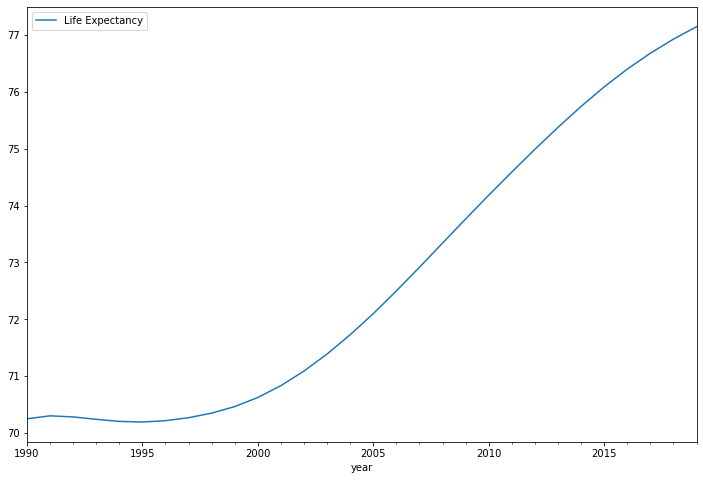

In [7]:
df[['Life Expectancy']].plot(figsize=(12,8))

<AxesSubplot:xlabel='year'>

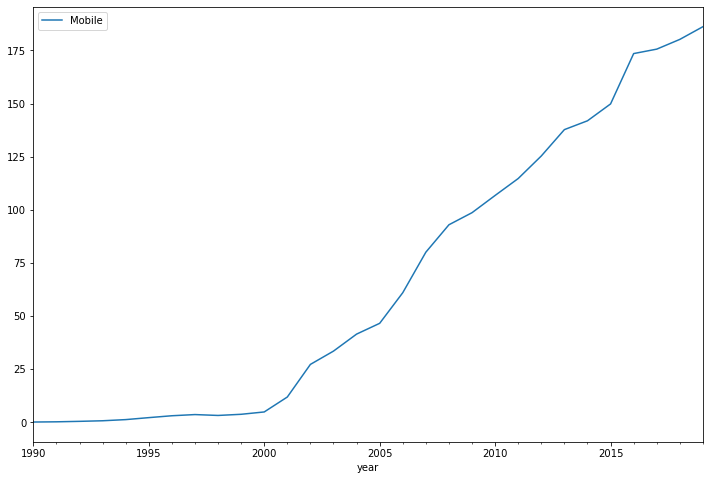

In [8]:
df[['Mobile']].plot(figsize=(12,8))

<AxesSubplot:xlabel='year'>

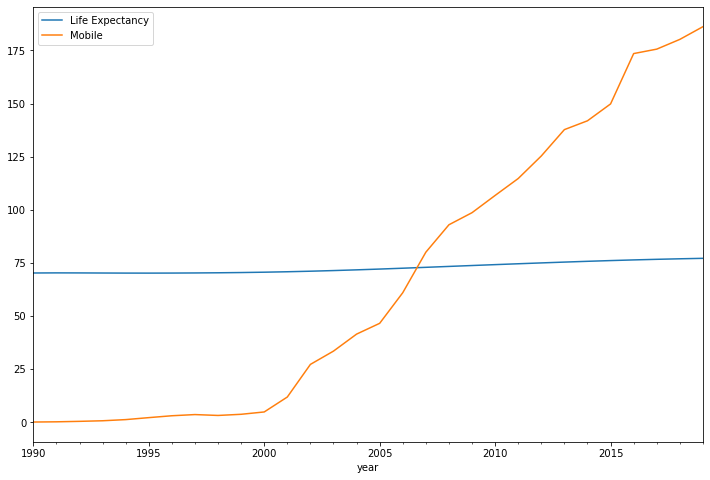

In [9]:
df.plot(figsize=(12,8))

<Figure size 432x288 with 0 Axes>

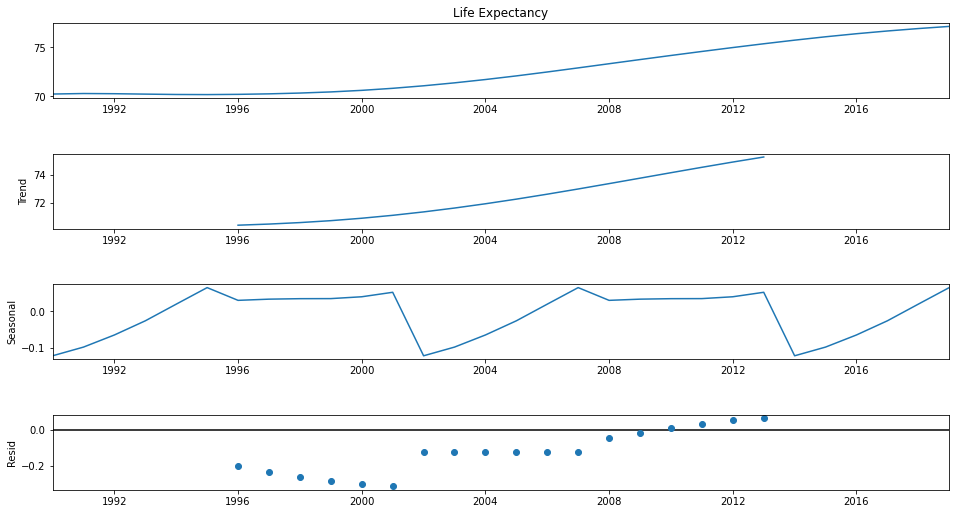

In [10]:
# From the plot above, we can see that seasonal pattern lasts for 12 months (1 year)
seasonal_period = 12
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['Life Expectancy'], period=seasonal_period)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

<Figure size 432x288 with 0 Axes>

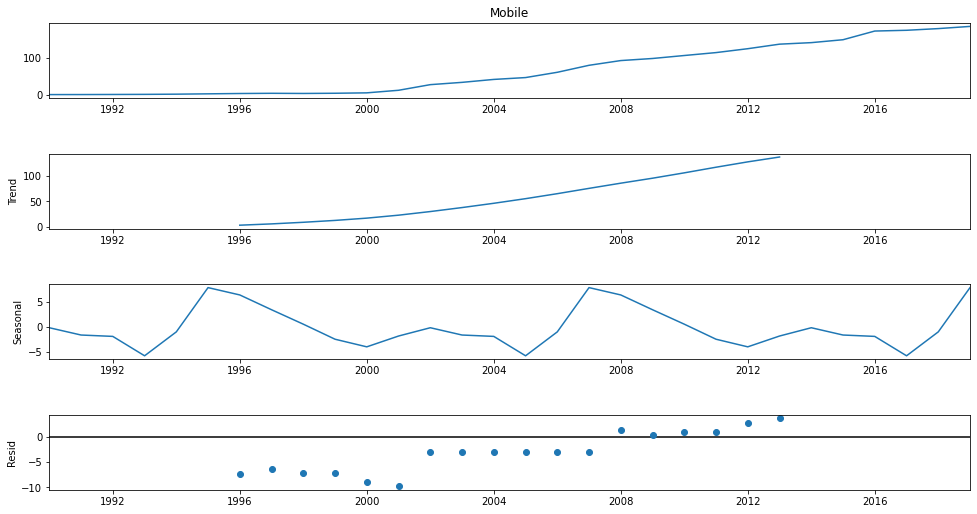

In [11]:
decomposition = seasonal_decompose(df['Mobile'], period=seasonal_period)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

## Mobile

#### Check Stationary, Autocorrelation (ACF), Partial Correlation (PACF)

In [12]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['Mobile'])
result

(2.2717421980497003,
 0.9989365264795831,
 0,
 29,
 {'1%': -3.6790595944893187,
  '5%': -2.9678817237279103,
  '10%': -2.6231583472057074},
 129.39771377114175)

In [13]:
def check_adfuller(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("Reject the null hypothesis. Data is stationary")
    else:
        print("Do not reject the null hypothesis. Data is not stationary ")

In [14]:
check_adfuller(df['Mobile'])

Augmented Dickey-Fuller Test:
ADF Test Statistic : 2.2717421980497003
p-value : 0.9989365264795831
#Lags Used : 0
Number of Observations Used : 29
Do not reject the null hypothesis. Data is not stationary 


<AxesSubplot:xlabel='year'>

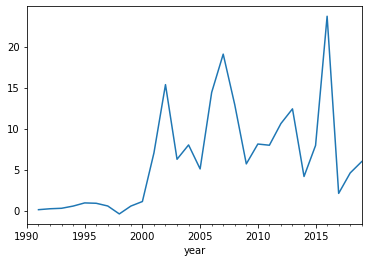

In [15]:
# Since the original timeseries is not stationary, we derive the first-order differenced series
df['First Difference'] = df['Mobile'] - df['Mobile'].shift(1)
df['First Difference'].plot()

In [16]:
# Check whether the first-order differenced series is stationary
check_adfuller(df['First Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -2.6661552528110617
p-value : 0.08008021363861173
#Lags Used : 1
Number of Observations Used : 27
Do not reject the null hypothesis. Data is not stationary 


In [17]:
# Since the first-order differenced series is stationary, we set difference parameter (d) = 1
d = 1

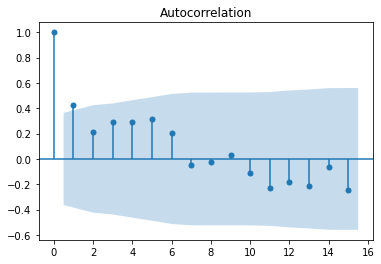

In [18]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig_first_acf = plot_acf(df["First Difference"].dropna())

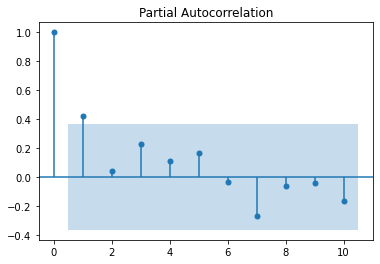

In [19]:
fig_first_pacf = plot_pacf(df["First Difference"].dropna(), lags=10, method='ywmle')

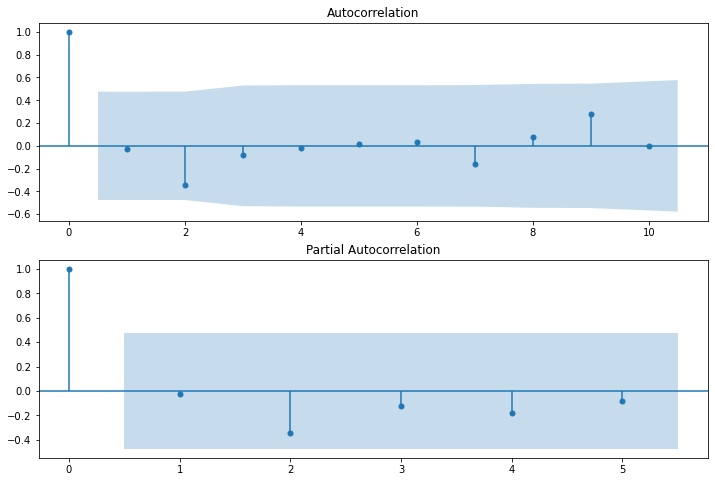

In [20]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['First Difference'].iloc[13:], lags=10, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['First Difference'].iloc[13:], method='ywmle', lags=5, ax=ax2)

In [21]:
from statsmodels.tsa.stattools import acf,pacf
df_pacf = pacf(df["First Difference"].dropna(), nlags=10 ,method='ols')
for i in range(0, len(df_pacf)):
    if df_pacf[i] < 1.96 / np.sqrt(len(df['Mobile'])):
        print("p= ", i-1)
        break

p=  1


In [22]:
df_acf = acf(df['Mobile'], fft= True)
for i in range(0, len(df_acf)):
    if df_acf[i] < 1.96 / np.sqrt(len(df['Mobile'])):
        print("q= ", i-1)
        break

q=  6


/Users/pantchanit/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(


In [23]:
# From ACF and PACF plots of seasonal part of timeseries, we set p = 2, and q = 2
p = 2
q = 2

#### ARIMA Model

In [24]:
print(p)
print(d)
print(q)

2
1
2


In [25]:
from statsmodels.tsa.arima.model import ARIMA
# Time index for ARIMA input must have freq parameter set.  
df = df.asfreq(df.index.inferred_freq, method='ffill')
# Run ARIMA 
model = ARIMA(df['Mobile'].dropna(), order=(p,d,q))
result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                 Mobile   No. Observations:                   30
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 -90.724
Date:                Thu, 07 Apr 2022   AIC                            191.448
Time:                        21:38:38   BIC                            198.284
Sample:                    01-01-1990   HQIC                           193.589
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4818      1.176      0.410      0.682      -1.823       2.787
ar.L2          0.4623      1.157      0.399      0.690      -1.806       2.731
ma.L1         -0.0517      1.127     -0.046      0.9

/Users/pantchanit/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pantchanit/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [26]:
# Let's try ARIMA with other values of p and q
model2 = ARIMA(df['Mobile'].dropna(),order=(1,d,1))
result2 = model2.fit()
print(result2.summary())

                               SARIMAX Results                                
Dep. Variable:                 Mobile   No. Observations:                   30
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -91.171
Date:                Thu, 07 Apr 2022   AIC                            188.341
Time:                        21:38:38   BIC                            192.443
Sample:                    01-01-1990   HQIC                           189.626
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9597      0.079     12.164      0.000       0.805       1.114
ma.L1         -0.6557      0.213     -3.086      0.002      -1.072      -0.239
sigma2        30.3042      7.034      4.308      0.0

In [27]:
# Let's try ARIMA with other values of p and q
model3 = ARIMA(df['Mobile'].dropna(),order=(0,d,0))
result3 = model3.fit()
print(result3.summary())

                               SARIMAX Results                                
Dep. Variable:                 Mobile   No. Observations:                   30
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -104.478
Date:                Thu, 07 Apr 2022   AIC                            210.956
Time:                        21:38:39   BIC                            212.324
Sample:                    01-01-1990   HQIC                           211.385
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        78.8489     18.453      4.273      0.000      42.682     115.016
Ljung-Box (L1) (Q):                   5.74   Jarque-Bera (JB):                 5.14
Prob(Q):                              0.02   Pr

In [28]:
from statsmodels.tsa.arima_model import ARIMAResults 
model = ARIMA(df['Mobile'].dropna(),order=(p,d,q))
result = model.fit()
print(result2.aic)
model2 = ARIMA(df['Mobile'].dropna(),order=(0,d,0))
result2 = model2.fit()
print(result2.aic)
model3 = ARIMA(df['Mobile'].dropna(),order=(1,d,1))
result3  =model3.fit()
print(result3.aic)
model4 = ARIMA(df['Mobile'].dropna(),order=(0,d,1))
result4  =model4.fit()
print(result4.aic)
model5 = ARIMA(df['Mobile'].dropna(),order=(1,d,0))
result5  =model5.fit()
print(result5.aic)

188.34139988564607
210.95636449305755
188.34139988564607
199.25597921234032
191.56018348041357


/Users/pantchanit/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pantchanit/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<AxesSubplot:xlabel='year'>

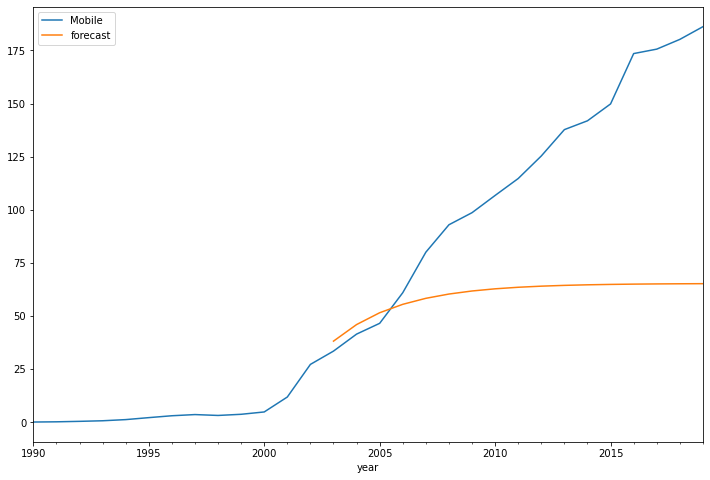

In [29]:
model5 = ARIMA(df['Mobile'].dropna(),order=(1,d,0))
result5  =model5.fit()

df['forecast'] = result5.predict(start = 13, end= 30, dynamic= True)  
df[['Mobile','forecast']].plot(figsize=(12,8))

In [30]:
from pandas.tseries.offsets import DateOffset
future_dates = [df.index[-1] + DateOffset(years=x) for x in range(0,10)]
future_dates

[Timestamp('2019-01-01 00:00:00'),
 Timestamp('2020-01-01 00:00:00'),
 Timestamp('2021-01-01 00:00:00'),
 Timestamp('2022-01-01 00:00:00'),
 Timestamp('2023-01-01 00:00:00'),
 Timestamp('2024-01-01 00:00:00'),
 Timestamp('2025-01-01 00:00:00'),
 Timestamp('2026-01-01 00:00:00'),
 Timestamp('2027-01-01 00:00:00'),
 Timestamp('2028-01-01 00:00:00')]

In [31]:
future_dates_df = pd.DataFrame(index=future_dates[1:],columns=df.columns)
future_df = pd.concat([df,future_dates_df])
future_df

,Life Expectancy,Mobile,First Difference,forecast
1990-01-01,70.248,0.111784,NaN,NaN
1991-01-01,70.300,0.215876,0.104092,NaN
1992-01-01,70.281,0.433454,0.217578,NaN
1993-01-01,70.239,0.708901,0.275447,NaN
1994-01-01,70.202,1.252280,0.543379,NaN
1995-01-01,70.191,2.182421,0.930141,NaN
1996-01-01,70.215,3.067722,0.885302,NaN
1997-01-01,70.267,3.622069,0.554347,NaN
1998-01-01,70.348,3.210122,-0.411947,NaN
1999-01-01,70.463,3.755144,0.545022,NaN


<AxesSubplot:>

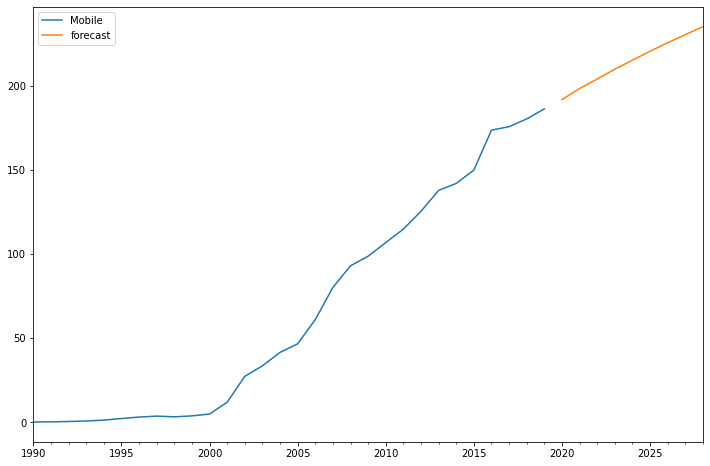

In [32]:
future_df['forecast'] = result.predict(start = 30, end = 40, dynamic= True)  
future_df[['Mobile', 'forecast']].plot(figsize=(12, 8))

<AxesSubplot:xlabel='year'>

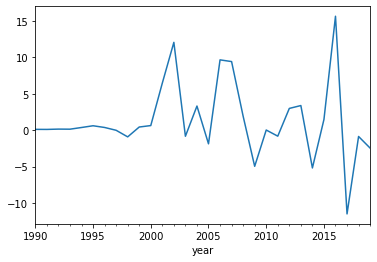

In [33]:
result.resid.plot()